In [4]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [24]:
#|export
# Python native modules
import os
import io
from typing import *
# Third party libs
import imageio
from fastcore.all import *
import matplotlib.pyplot as plt
import torchdata.datapipes as dp
from IPython.core.display import Video,Image
from torchdata.dataloader2.dataloader2 import DataLoader2
# Local modules
from fastrl.core import *
from fastrl.loggers.core import *
from fastrl.data.dataloader2 import *
from fastrl.data.block import *
from fastrl.pipes.core import *
from fastrl.loggers.jupyter_visualizers import ImageCollector

In [25]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [26]:
#|default_exp loggers.vscode_visualizers

# Visualizers - VS-Code
> Iterable pipes for displaying environments as they run using `typing.NamedTuples` with `image` fields for VS-Code

`fastrl.jupyter_visualizers` can be used in vscode, however you likely will notice flickering for video
based outputs. For vscode, we can generate a gif instead.

In [38]:
#|export
class SimpleVSCodeVideoPlayer(LoggerBase):
    def __init__(self, 
                 source_datapipe=None, 
                 skip_frames:int=1,
                 fps:int=30,
                 downsize_res=(2,2)
        ):
        super().__init__(source_datapipe)
        self.source_datapipe = source_datapipe
        self.fps = fps
        self.skip_frames = skip_frames
        self.downsize_res = downsize_res
        self._bytes_object = None
        self.frames = [] 

    def reset(self):
        super().reset()
        self._bytes_object = io.BytesIO()

    def show(self,start:int=0,end:Optional[int]=None,step:int=1):
        print(f'Creating gif from {len(self.frames)} frames')
        imageio.mimwrite(
            self._bytes_object,
            self.frames[start:end:step],
            format='GIF',
            fps=self.fps
        )
        return Image(self._bytes_object.getvalue())
        
    def __iter__(self) -> typing.Tuple[typing.NamedTuple]:
        n_frame = 0
        for record in self.source_datapipe:
            for o in self.dequeue():
                if o.value is None: continue
                n_frame += 1
                if n_frame%self.skip_frames!=0: continue
                self.frames.append(
                    o.value[::self.downsize_res[0],::self.downsize_res[1]]
                )
            yield record
add_docs(
SimpleVSCodeVideoPlayer,
"""Displays video from a `source_datapipe` that produces `typing.NamedTuples` that contain an `image` field.
This only can handle 1 env input.""",
dequeue="Grabs records from the `main_queue` and attempts to display them",
show="In order to show the video, this must be called in a notebook cell.",
reset="Will reset the bytes object that is used to store file data."
)

In [39]:
#|export
def VSCodeTransformBlock(
    # Additional pipelines to insert, replace, remove
    dp_augmentation_fns:Tuple[DataPipeAugmentationFn]=None
) -> TransformBlock:
    "Basic OpenAi gym `DataPipeGraph` with first-last, nstep, and nskip capability"
    def _VSCodeTransformBlock(
        # `source` likely will be an iterable that gets pushed into the pipeline when an 
        # experiment is actually being run.
        source:Any,
        # Any parameters needed for the dataloader
        num_workers:int=0,
        # This param must exist: as_dataloader for the datablock to create dataloaders
        as_dataloader:bool=False
    ) -> DataPipeOrDataLoader:
        "This is the function that is actually run by `DataBlock`"
        video_logger = SimpleVSCodeVideoPlayer()
        pipe = LoggerBasePassThrough(source,[video_logger])
        pipe = ImageCollector(pipe)
        pipe = video_logger.connect_source_datapipe(pipe)
        pipe = apply_dp_augmentation_fns(pipe,ifnone(dp_augmentation_fns,()))
        
        if as_dataloader:
            pipe = DataLoader2(
                datapipe=pipe,
                reading_service=PrototypeMultiProcessingReadingService(
                    num_workers = num_workers,
                    protocol_client_type = InputItemIterDataPipeQueueProtocolClient,
                    protocol_server_type = InputItemIterDataPipeQueueProtocolServer,
                    pipe_type = item_input_pipe_type,
                    eventloop = SpawnProcessForDataPipeline
                ) if num_workers>0 else None
            )
        return pipe 
    return _VSCodeTransformBlock

In [40]:
import pandas as pd
from fastrl.pipes.core import *
from fastrl.pipes.map.transforms import *
from fastrl.envs.gym import GymTypeTransform,GymStepper

def gym_pipe_base(envs,total_steps,seed=0):
    pipe = dp.map.Mapper(envs)
    pipe = TypeTransformer(pipe,[GymTypeTransform])
    pipe = dp.iter.MapToIterConverter(pipe)
    pipe = dp.iter.InMemoryCacheHolder(pipe)
    pipe = pipe.cycle(count=total_steps)
    pipe = GymStepper(pipe,seed=seed,include_images=True)
    return pipe

/opt/conda/lib/python3.7/site-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


Creating gif from 100 frames


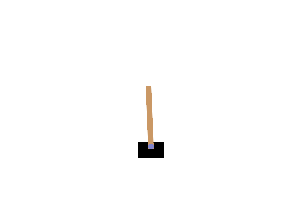

In [41]:

video_logger = SimpleVSCodeVideoPlayer()

pipe = gym_pipe_base(['CartPole-v1'],100)
pipe = VSCodeTransformBlock()(pipe)

L(pipe);
pipe.show()

In [42]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()